<a href="https://colab.research.google.com/github/aryannuka/data-science/blob/main/Copy_of_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

Draw a decision tree by hand that uses exercise time to predict calories burned. Also create a simple scatter plot with exercise time on the x‑axis and calories burned on the y‑axis.

A decision tree is a model that splits data based on simple rules. It follows branches from a root node to leaves where predictions are made.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is the number of layers of splits from the root to the deepest leaf depending on the amnount of data. A very deep tree can overfit , while a shallow tree might underfit.

**Task4:**

How are BART models similar and different from a decision tree?

BART is essentially an ensemble of decision trees, with each tree capturing different trends in the data. This approach is similar to a random forest, where many decision trees are generated by randomizing their root nodes and then combined. The main difference is that BART builds its trees sequentially, which encourages each tree to identify unique patterns.

**Task5**:

Why would we use a BART model instead of a decision tree?

We use BART instead of a single tree because it reduces overfitting, gives uncertainty estimates, and captures complex non-linear relationships.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [1]:
#drop the incomplete rows from the dat
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

  Using cached preliz-0.16.0-py3-none-any.whl.metadata (6.1 kB)
Using cached preliz-0.16.0-py3-none-any.whl (519 kB)


In [3]:
features = ["flipper_length", "bill_length","bill_depth"]

X = penguins[features]
Y = penguins["body_mass"].to_numpy()
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

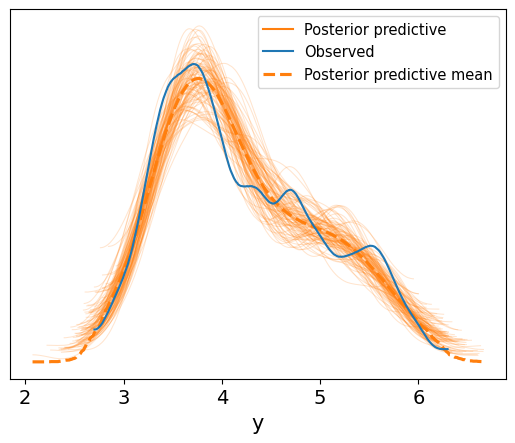

In [4]:
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


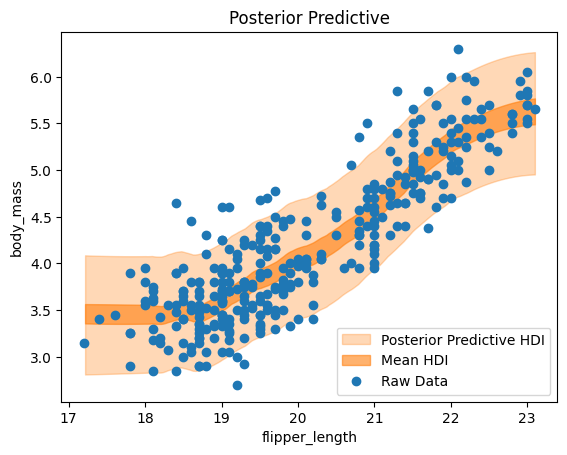

In [7]:
posterior_mean = idata_octps.posterior["μ"]

μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

Xn = X.to_numpy()

idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)
az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

The plot shows a clear positive relationship between flipper length and body mass: as flipper length increases, body mass generally goes up. Most data points are within the orange predictive band, showing us that the model captures the overall trend well. However, some points are near the edge or slightly outside the band, indicating there is still variability the model might not fully capture. The band also widens a bit for larger flipper lengths, reflecting increased uncertainty in that region. Overall, it looks like a good fit to the main pattern, but it does not capture everything as any species-specific differences or other factors that also affect body mass.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

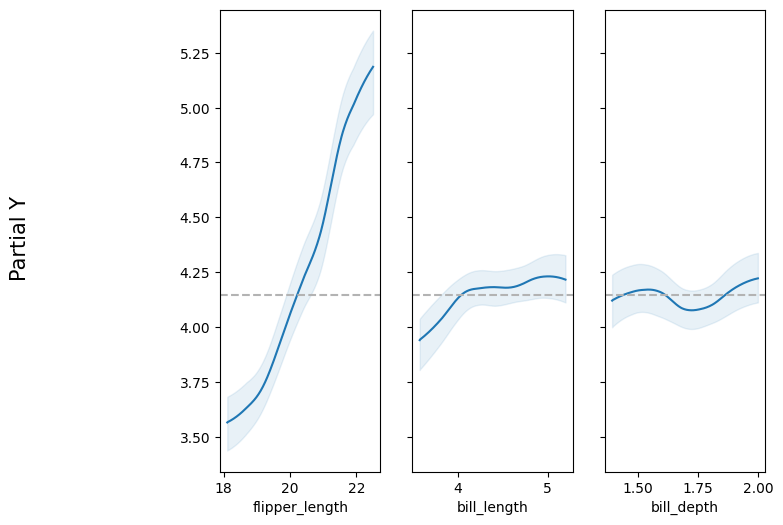

In [8]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

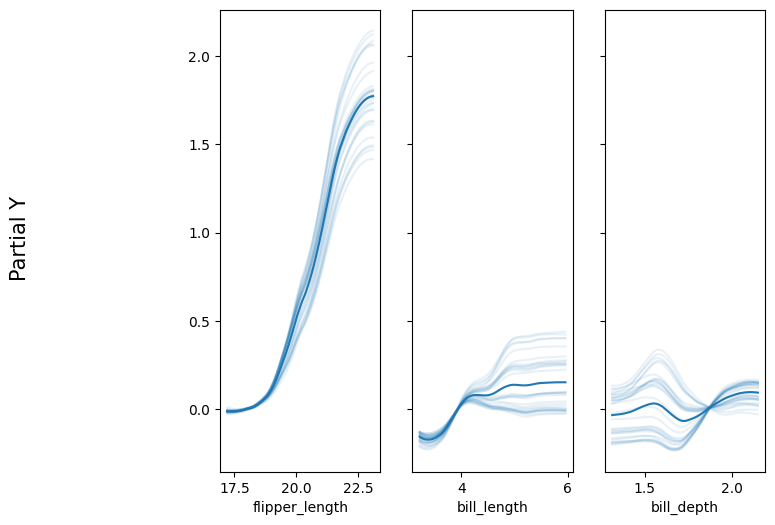

In [9]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

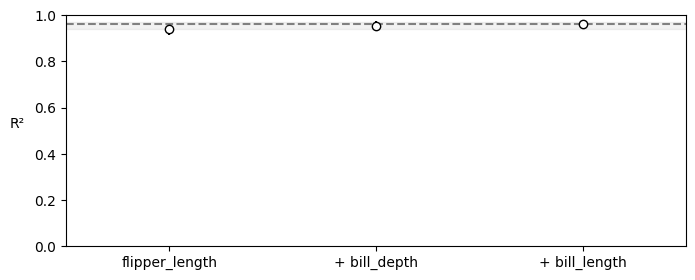

In [10]:
vi_counties = pmb.compute_variable_importance(idata_octps, μ_, X)
pmb.plot_variable_importance(vi_counties)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

From the variable importance plot, flipper length is the key driver of body mass. The partial dependence plot for flipper length shows a strong positive slope, meaning that, after controlling for bill length and depth, longer flippers predict heavier body mass. Bill length and bill depth, on the other hand, have much flatter partial dependence curves, suggesting they add less predictive power.

The ICE plots for flipper length reveal large vertical gaps, showing that different penguins vary widely in how much weight is associated with a given flipper length, but the lines remain fairly parallel—indicating no strong interaction with the other features. By contrast, if the bill‐length or bill‐depth ICE lines were more spread out and crossed each other a lot, we would suspect interactions. Because those lines stay relatively flat, we see only a small effect from those variables and limited evidence of major interactions.